In [22]:
#######imports and data read#######
import copy
import time
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import scPrisma
import h5py
import anndata
import scanpy as sc
from sklearn.metrics import adjusted_rand_score

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# adata = anndata.read_h5ad("../data/cellcycle_maxine/RPE_37C_Rep1_full.h5ad")
DATA_FOLDER = "../../../../data/"
adata = anndata.read_h5ad(f"{DATA_FOLDER}cellcycle_maxine/VASA_preprocesseed.h5ad")
adata

AnnData object with n_obs × n_vars = 38913 × 16011
    obs: 'Cell_ID', 'obs_names', 'Stage', 'Dataset', 'G0?', 'UMAP_phase', 'UMI_SUM', 'S-phase', 'Celltype', 's_counts', 'u_counts', 'percent_unspliced', 'total_counts', 'pca_theta'
    var: 'var_names', 'Type', 'n_cells'
    uns: 'log1p'
    layers: 'matrix', 's_log', 's_norm', 'spliced', 'u_log', 'u_norm', 'unspliced'

In [28]:
adata.X = adata.layers["spliced"].toarray().astype(np.float32)

In [29]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
orig_adata = adata.copy()
sc.pp.filter_genes_dispersion(adata, n_top_genes=7000)

/tmp/ipykernel_861571/3993271568.py:1: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)


/home/maxine/miniconda3/envs/scPrismaEnv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:590: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/tmp/ipykernel_861571/3993271568.py:4: FutureWarning: Use sc.pp.highly_variable_genes instead
  sc.pp.filter_genes_dispersion(adata, n_top_genes=7000)
/home/maxine/miniconda3/envs/scPrismaEnv/lib/python3.10/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:137: FutureWarning: Use sc.pp.highly_variable_genes instead
  result = filter_genes_dispersion(
/home/maxine/miniconda3/envs/scPrismaEnv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  return fn(*args_all, **kw)


In [30]:
adata = adata[adata.obs.sample(frac=0.2, random_state=1).index].copy()

In [31]:
E_sga, E_rec_sga = scPrisma.algorithms_torch.reconstruction_cyclic_torch(
    adata.X, iterNum=100
)

Iteration number: 
0
Iteration number: 
25
Iteration number: 
50
Iteration number: 
75
torch.cuda.memory_allocated: 8.066644GB


In [32]:
sga_range = scPrisma.algorithms_torch.e_to_range(E_rec_sga)
adata = adata[sga_range, :]
orig_adata = copy.deepcopy(adata.copy())

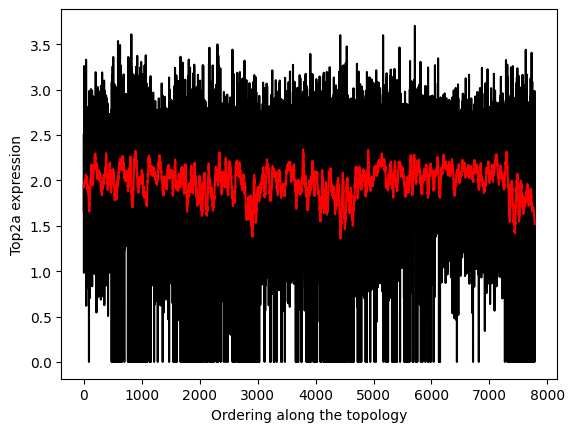

/home/maxine/miniconda3/envs/scPrismaEnv/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


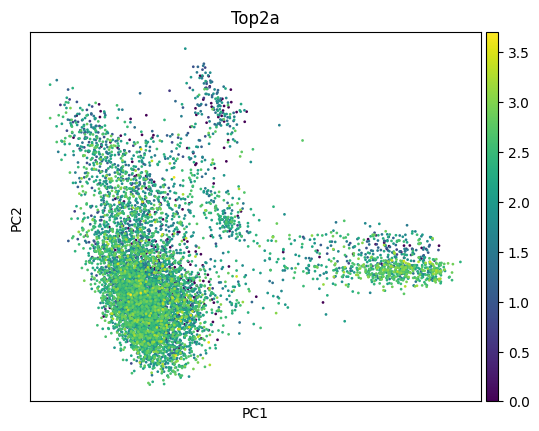

In [33]:
plt.plot(adata[:, "Top2a"].X[:, 0], color="black")  # Peaktime at S
plt.plot(savgol_filter(adata[:, "Top2a"].X[:, 0], 70, 2), color="r")

plt.ylabel("Top2a expression")
plt.xlabel("Ordering along the topology")
plt.show()
sc.pp.pca(adata)
sc.pl.pca(adata, color=["Top2a"])

Iteration number: 
1
Iteration number: 
26
Iteration number: 
51
Iteration number: 
76


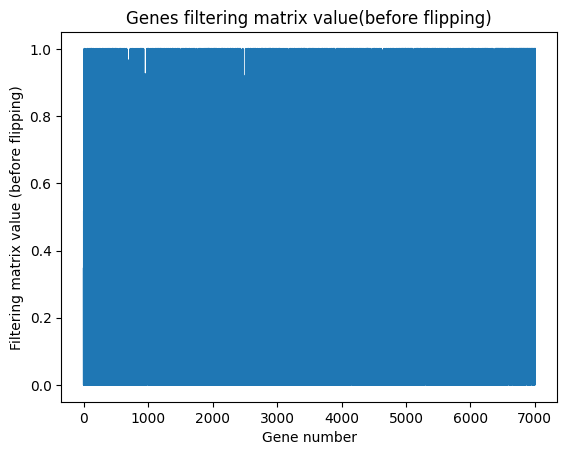

In [34]:
D = scPrisma.algorithms_torch.filter_cyclic_genes_torch(adata.X, regu=0.8, iterNum=100)
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

In [35]:
D_flipped = np.identity(D.shape[0]) - D
adata_enhancement = adata.copy()
adata_enhancement.X = adata_enhancement.X.dot(D_flipped)

starting enhancement on cuda
Iteration number: 1
torch.cuda.memory_allocated: 6.043499GB


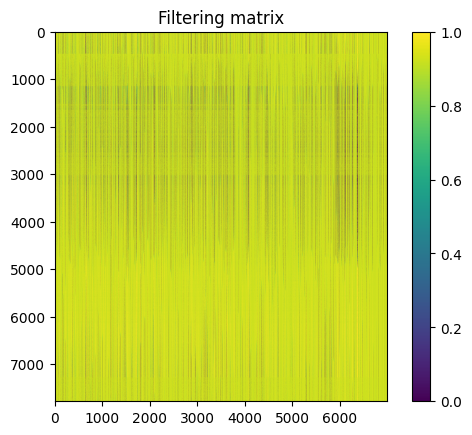

In [36]:
F = scPrisma.algorithms_torch.enhancement_cyclic_torch(
    adata_enhancement.X, regu=0.01, iterNum=100
)

plt.imshow(F)
plt.title("Filtering matrix")
plt.colorbar()
plt.show()

In [37]:
adata_enhancement.X = adata_enhancement.X * F